In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from prince import MCA
from sklearn.model_selection import train_test_split
import pycrfsuite
from sklearn.cluster import KMeans 

In [3]:
# Load Z-score matrix
z_score_matrix = np.load(os.path.expanduser('~/downloads/spkszsel_intp.npy'))

# transpose the matrix
z_score_matrix = z_score_matrix.T

In [4]:
#print the shape of the matrix to see the dimensions
print(z_score_matrix.shape)

(36660, 3327)


In [5]:
# thresholding the z_score_matrix to create a binary matrix
threshold = 2.0  

binary_matrix = np.where(z_score_matrix >= threshold, 1, 0) 

In [9]:
#convert the binary matrix to a dataframe
binary_matrix_df = pd.DataFrame(binary_matrix)

mca = MCA(
    n_components=2,  # Number of components to keep
    n_iter=10,        # Number of iterations for the algorithm (adjust if needed)
    copy=True,        # Keep original data intact
    check_input=True, # Validate input data
    engine='sklearn'    # Engine for the analysis 
)

mca = mca.fit(binary_matrix_df) 


<Axes: xlabel='0', ylabel='1'>

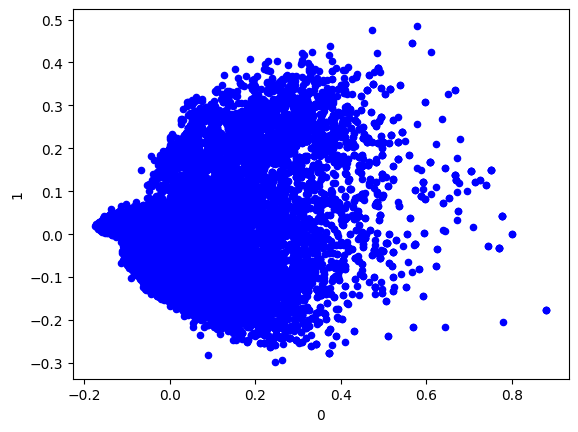

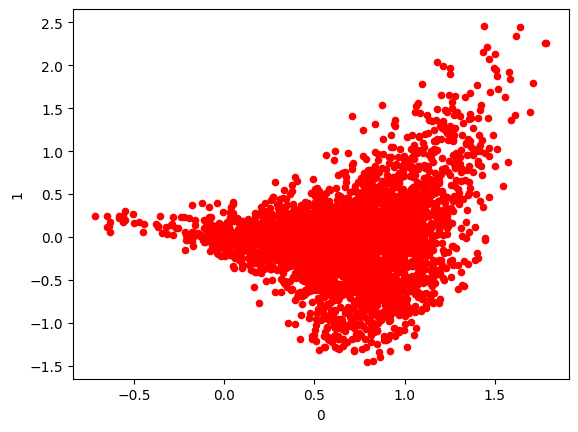

In [11]:
# Plotting row coordinates (individual data points)
mca.row_coordinates(binary_matrix_df).plot(kind='scatter', x=0, y=1, color='blue')

# Plotting column coordinates (binary variables)
mca.column_coordinates(binary_matrix_df).plot(kind='scatter', x=0, y=1, color='red')


In [5]:
data = np.load(os.path.expanduser('~/downloads/behav_coord_likeli_norm.npy'))
data = np.transpose(data)
# print the first 10 rows in the first column



# plot the derivative of the first 10 rows in the first column against the index

# make a table of two rows and 8 columns, the first row is these labels in order: 'IFx', 'IFy', 'CFx', 'CFy', 'IHx', 'IHy', 'CHx', 'CHy', the second row is the first 10 rows of the data in the same order.






In [6]:
# Create the labels
labels = ['IFx', 'IFy', 'CFx', 'CFy', 'IHx', 'IHy', 'CHx', 'CHy']

# Create a DataFrame with the labels and data
df = pd.DataFrame(data, columns=labels)

# Display the DataFrame


# calculate the relative displacement of each point relative to the previous point in the same column  
displacement = df.diff()

#take the absolute value of the displacement
displacement = displacement.abs()

In [7]:
# print the last 500 rows of the displacement
print(displacement.tail(500))

            IFx       IFy       CFx       CFy       IHx       IHy       CHx  \
36160  0.000679  0.004060  0.002083  0.004862  0.002124  0.003334  0.001443   
36161  0.000496  0.000587  0.002480  0.003166  0.004739  0.002416  0.001487   
36162  0.000906  0.004215  0.000069  0.000783  0.002788  0.002874  0.000280   
36163  0.003790  0.009647  0.001065  0.001215  0.002524  0.002869  0.000206   
36164  0.003387  0.000525  0.001213  0.001745  0.003211  0.000494  0.000095   
...         ...       ...       ...       ...       ...       ...       ...   
36655  0.039876  0.043883  0.069005  0.035387  0.035293  0.297820  0.073469   
36656  0.513732  0.073781  0.076003  0.080965  0.131137  0.011060  0.034576   
36657  0.014674  0.295617  0.115609  0.082168  0.176421  0.047920  0.197511   
36658  0.103564  0.195625  0.110110  0.086037  0.195661  0.012410  0.190402   
36659  0.154315  0.211343  0.093523  0.096176  0.217499  0.053532  0.162965   

            CHy  
36160  0.000317  
36161  0.000406

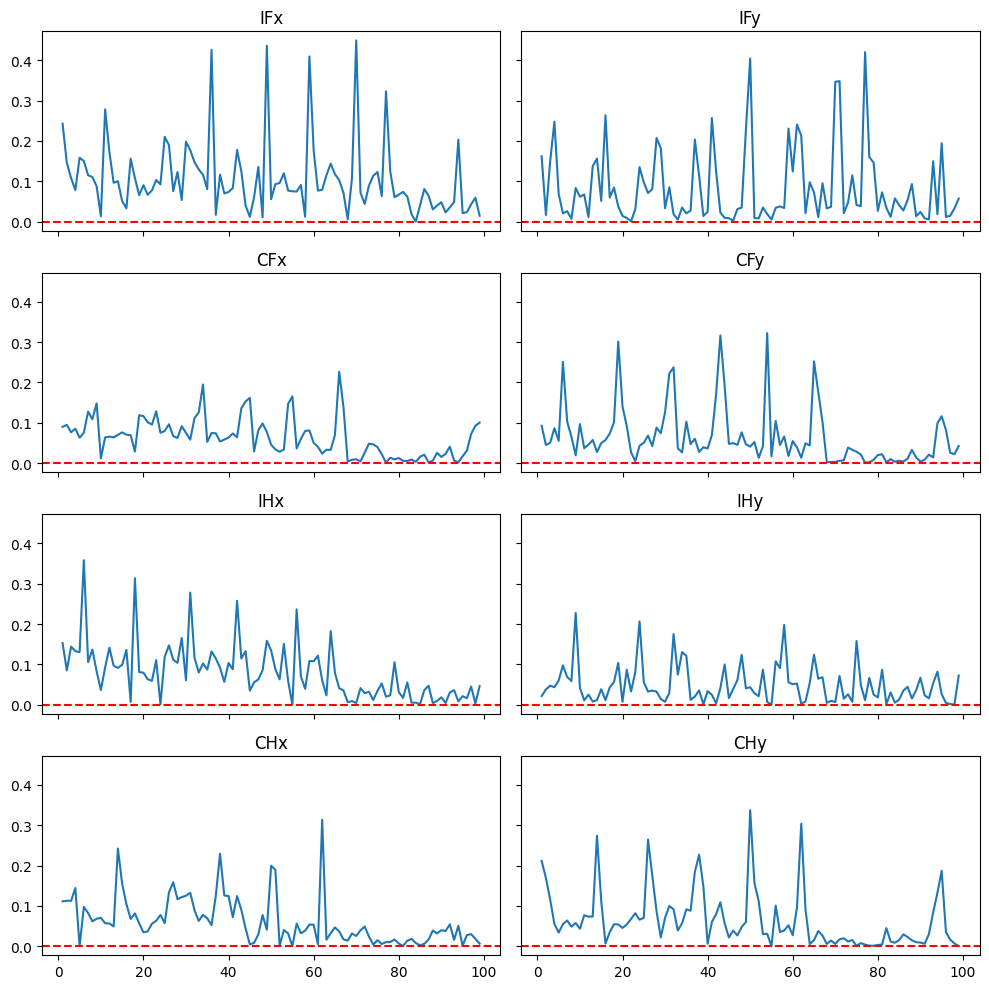

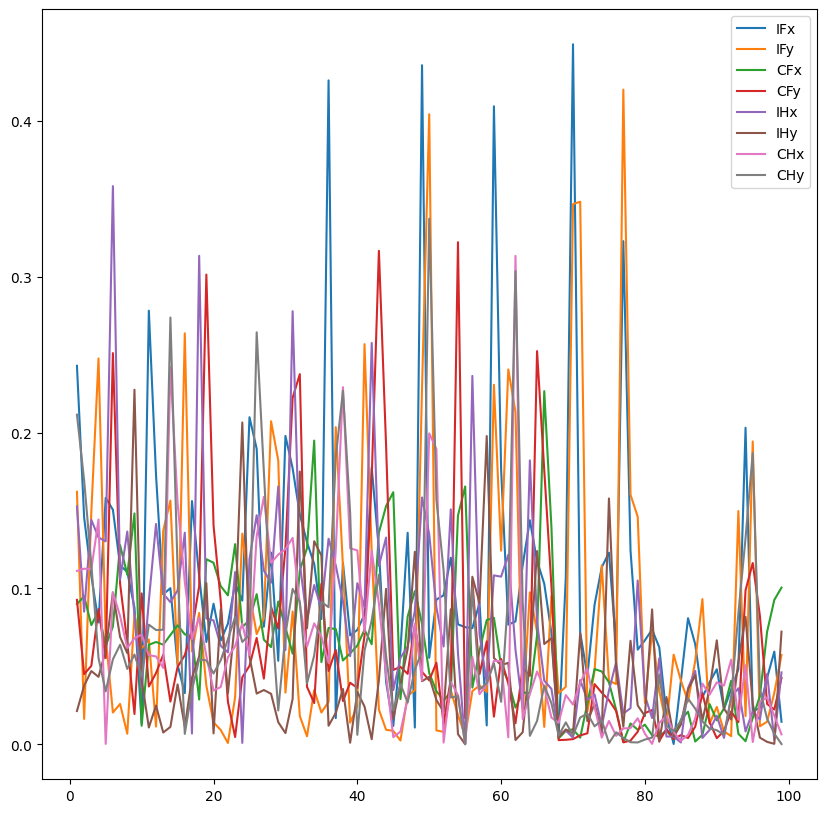

In [8]:
# plot the first 100 rows in the first 8 column against the index in 8 different plots
fig, axs = plt.subplots(4, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    ax.plot(displacement[labels[i]][:100])
    ax.axhline(0, color='r', linestyle='--')
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()
# plot the first 100 rows in the first 8 column against the index in one plot
displacement[:100].plot(figsize=(10, 10))
plt.show()

In [9]:
# use this algorithm to write a rule-based classifier that classifies the data into 3 classes: 'stance', 'swing', 'transition' based on the relative displacement of the points. The classes are defined as follows:
#IF displacement < 0.05 AND this state has been held for at least 3 frames:
    #Phase = "Stance"
#ELSE IF displacement >= 0.15:
    #Phase = "Swing"
#ELSE:
    #Phase = "Transition" 
#The classifier should output an array of strings with the same length as the input data, where each element is the class of the corresponding element in the input data.

classes = {label: [] for label in labels}
counters = {label: 0 for label in labels}
prev_classes = {label: '' for label in labels}

for i in range(len(displacement)):
    for label in labels:
        if displacement[label].iloc[i] < 0.05:  # Stance check first
            if counters[label] >= 3:
                classes[label].append('Stance')
                prev_classes[label] = 'Stance'
            else:
                classes[label].append('Transition')  # Add this line
            counters[label] += 1  
        elif displacement[label].iloc[i] >= 0.15:  # Swing check
            classes[label].append('Swing')
            prev_classes[label] = 'Swing'
            counters[label] = 1
        else:  # Transition
            classes[label].append('Transition')
            prev_classes[label] = 'Transition'
            counters[label] = 1

        if prev_classes[label] != classes[label][-1]:
            counters[label] = 1 

classes_df = pd.DataFrame(classes)



In [10]:
# print the first 10 rows of classes_df
print(classes_df.head(10))


          IFx         IFy         CFx         CFy         IHx         IHy  \
0  Transition  Transition  Transition  Transition  Transition  Transition   
1       Swing       Swing  Transition  Transition       Swing  Transition   
2  Transition  Transition  Transition  Transition  Transition  Transition   
3  Transition  Transition  Transition  Transition  Transition      Stance   
4  Transition       Swing  Transition  Transition  Transition      Stance   
5       Swing  Transition  Transition  Transition  Transition  Transition   
6       Swing  Transition  Transition       Swing       Swing  Transition   
7  Transition  Transition  Transition  Transition  Transition  Transition   
8  Transition      Stance  Transition  Transition  Transition  Transition   
9  Transition  Transition  Transition  Transition  Transition       Swing   

          CHx         CHy  
0  Transition  Transition  
1  Transition       Swing  
2  Transition       Swing  
3  Transition  Transition  
4  Transitio

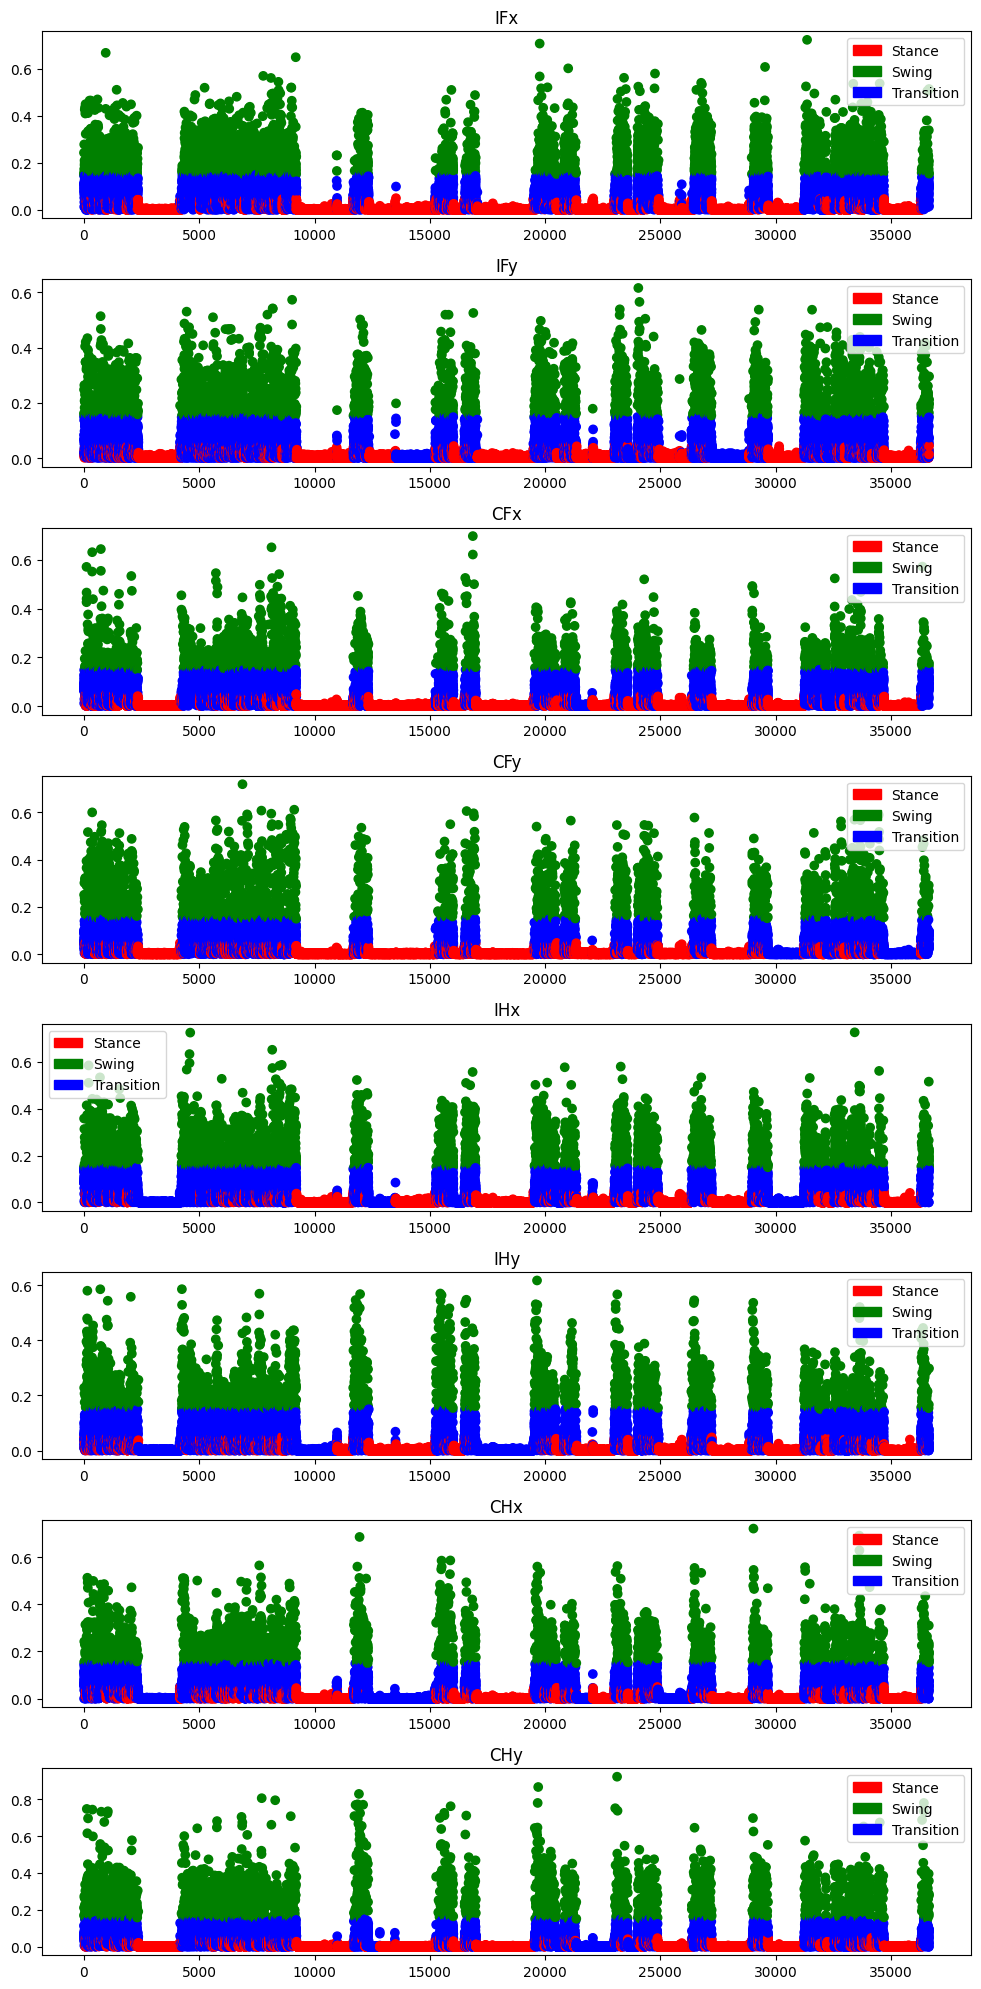

In [11]:
#Plot displacement for each limb, but now OVERLAY the classified phases with different colors for each phase.

colors = {'Stance': 'red', 'Swing': 'green', 'Transition': 'blue'}

# Create legend handles
legend_handles = [mpatches.Patch(color=color, label=phase) for phase, color in colors.items()]

fig, axs = plt.subplots(len(labels), figsize=(10, 20))

for i, label in enumerate(labels):
    axs[i].scatter(range(len(displacement)), displacement[label], c=[colors[phase] for phase in classes_df[label]])
    axs[i].set_title(label)
    axs[i].legend(handles=legend_handles)

plt.tight_layout()
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

# Step 1: Prepare data for splitting
x = classes_df  # Your movement phases
y = binary_matrix  # One-hot encoded cluster labels

# Define movement phases (Make sure this is complete!)
movement_phases = ['Stance', 'Swing', 'Transition']  

# Create a mapping from movement phases to integers
movement_phase_to_int = {phase: i for i, phase in enumerate(movement_phases)}


# Step 2: Split the data into training and testing sets (80% train, 20% test) 
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# convert the x_test, the x_train, the y_test, and the y_train  to a format that can be used by the pycrfsuite library
def transform_data(x, y):
    transformed_x = []
    transformed_y = []

    for x_sample, y_sample in zip(x, y):
        transformed_x_sample = [{'feature': value} for value in x_sample]
        transformed_y_sample = [int(float(label)) for label in y_sample]  # Convert to int
        transformed_x.append(transformed_x_sample)
        transformed_y.append(transformed_y_sample)

    return transformed_x, transformed_y

# Convert DataFrames to lists of lists
x = classes_df.values.tolist()
y = binary_matrix.tolist() 

# Transform the data
x, y = transform_data(x, y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [13]:
#print the first 5rows of x_train, y_train
print(x_train[:5])
print(y_train[:5])

#print the shape of x_train, y_train
print(len(x_train))
print(len(y_train))

[[{'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}], [{'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}], [{'feature': 'Swing'}, {'feature': 'Transition'}, {'feature': 'Transition'}, {'feature': 'Transition'}, {'feature': 'Transition'}, {'feature': 'Transition'}, {'feature': 'Transition'}, {'feature': 'Transition'}], [{'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}], [{'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Stance'}, {'feature': 'Transition'}, {'feature': 'Stance'}, {'feature': 'Stance'}]]
[[0, 0, 0, 0, 0, 0

In [15]:
import pycrfsuite

from tqdm import tqdm

# Create a CRF model
crf_model = pycrfsuite.Trainer(verbose=True)

# Add training features
for sentence, labels in tqdm(zip(x_train, y_train), total=len(x_train)):
    features = [feature for token in sentence for feature in token.values()]
    str_labels = [str(movement_phase) for movement_phase in features]  
    str_labels_y = [str(labels.index(1))] * len(str_labels) 
    crf_model.append(str_labels, str_labels_y)

# Train the CRF model
crf_model.train('crf.model')  # Replace with desired filename 


100%|██████████| 29328/29328 [00:00<00:00, 78052.38it/s]


Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 7306
Seconds required: 0.160

L-BFGS optimization
c1: 0.000000
c2: 1.000000
num_memories: 6
max_iterations: 2147483647
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 1186089.946599
Feature norm: 5.000000
Error norm: 88326.022671
Active features: 7306
Line search trials: 2
Line search step: 0.000060
Seconds required for this iteration: 370.421

***** Iteration #2 *****
Loss: 1124200.537504
Feature norm: 6.980987
Error norm: 76762.465841
Active features: 7306
Line search trials: 2
Line search step: 0.423096
Seconds required for this iteration: 246.528

***** Iteration #3 *****
Loss: 1080331.270121
Feature norm: 7.752453
Error norm: 54881.984696
Active features: 7306
Line search trials: 1
Line search step: 1.000000
Seconds